# Importação do Dataset

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Carregar os dados
file_path = 'dataset_shrink_transformed.npz'  # Ajuste o caminho conforme necessário
data = np.load(file_path)
arr_0 = data['arr_0']
arr_1 = data['arr_1']

# Criar DataFrame com os dados do sensor
dates = pd.to_datetime(arr_1)
sensor_data = pd.DataFrame(arr_0, index=dates)

# Exibir as primeiras linhas do DataFrame para verificar se os dados foram carregados corretamente
print(sensor_data.head())

                                    0          1          2          3  \
2015-10-09 23:48:31.152250 -58.906185 -58.763771 -58.896015 -58.723080   
2015-10-09 23:48:31.160250 -58.906185 -58.794289 -58.896015 -58.896015   
2015-10-09 23:48:31.168250 -58.967220 -58.957050 -58.896015 -59.068947   
2015-10-09 23:48:31.176250 -59.119808 -59.089291 -59.058773 -58.896015   
2015-10-09 23:48:31.184250 -59.282570 -59.119808 -59.231709 -59.068947   

                                    4          5          6          7  \
2015-10-09 23:48:31.152250 -59.119808 -58.855324 -58.916359 -58.763771   
2015-10-09 23:48:31.160250 -59.119808 -58.896015 -58.916359 -58.763771   
2015-10-09 23:48:31.168250 -58.957050 -58.896015 -58.916359 -59.079121   
2015-10-09 23:48:31.176250 -59.282570 -59.170673 -59.079121 -59.109638   
2015-10-09 23:48:31.184250 -59.119808 -59.170673 -59.241879 -59.109638   

                                    8          9  
2015-10-09 23:48:31.152250 -58.723080 -58.529804  
2015-10-

# Sensor 1

## Decomposição do Sinal

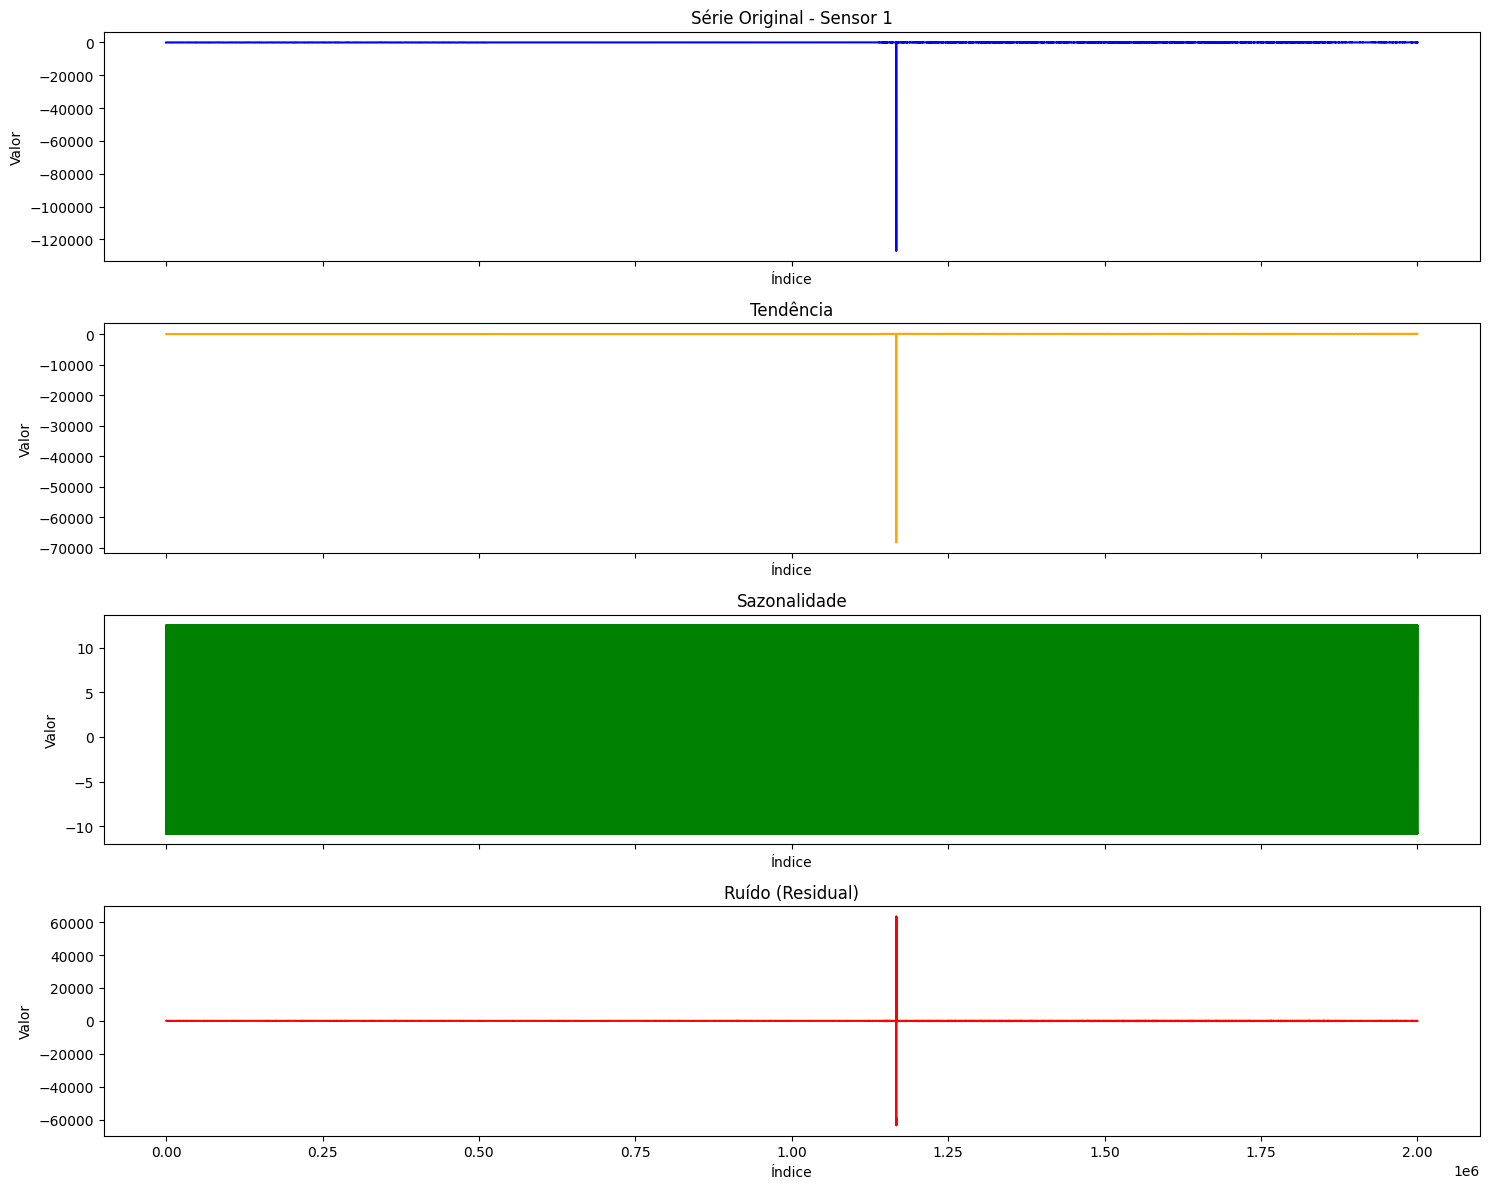

In [7]:
# Selecionar os dados do Sensor 1
sensor = 1
sensor_index = sensor - 1

# Selecionar os dados do Sensor 1
sensor_data_sample = sensor_data.iloc[:, sensor_index]

# Decompor os dados do Sensor 1
result = seasonal_decompose(sensor_data_sample, model='additive', period=365)

# Criando uma lista de índices para representar o eixo x
indices = range(len(sensor_data_sample))

# Plotando os componentes com Matplotlib
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

# Plotar a série original
axes[0].plot(indices, sensor_data_sample, color='blue')
axes[0].set_title(f'Série Original - Sensor {sensor}')
axes[0].set_ylabel('Valor')
axes[0].set_xlabel('Índice')

# Plotar a tendência
axes[1].plot(indices, result.trend, color='orange')
axes[1].set_title('Tendência')
axes[1].set_ylabel('Valor')
axes[1].set_xlabel('Índice')

# Plotar a sazonalidade
axes[2].plot(indices, result.seasonal, color='green')
axes[2].set_title('Sazonalidade')
axes[2].set_ylabel('Valor')
axes[2].set_xlabel('Índice')

# Plotar o ruído (residual)
axes[3].plot(indices, result.resid, color='red')
axes[3].set_title('Ruído (Residual)')
axes[3].set_ylabel('Valor')
axes[3].set_xlabel('Índice')

# Ajustar layout
plt.tight_layout()
plt.show()

## Verificação da Sazonalidade

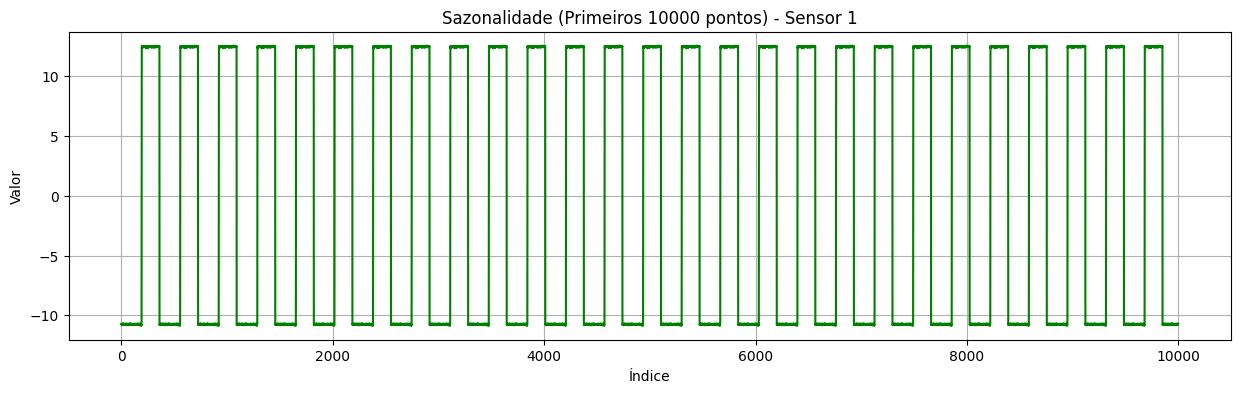

Média da Sazonalidade: -0.00
Desvio Padrão da Sazonalidade: 11.57


In [8]:
# Plotando a sazonalidade (exibindo apenas os primeiros 10.000 pontos)
index_start_saz = 0
index_end_saz = 10000

plt.figure(figsize=(15, 4))
plt.plot(indices[index_start_saz:index_end_saz + index_start_saz],
         result.seasonal[index_start_saz:index_end_saz + index_start_saz], color='green')
plt.title(f'Sazonalidade (Primeiros {index_end_saz} pontos) - Sensor {sensor}')
plt.ylabel('Valor')
plt.xlabel('Índice')
plt.grid()
plt.show()

# Análise estatística simples da sazonalidade
mean_seasonal = np.mean(result.seasonal)
std_seasonal = np.std(result.seasonal)

print(f'Média da Sazonalidade: {mean_seasonal:.2f}')
print(f'Desvio Padrão da Sazonalidade: {std_seasonal:.2f}')

## Verificação do Ruído (Residual)

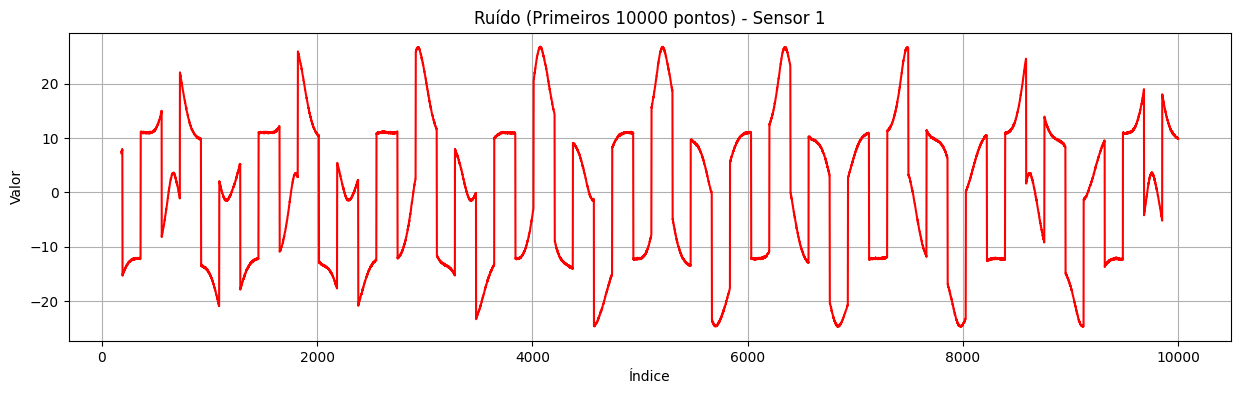

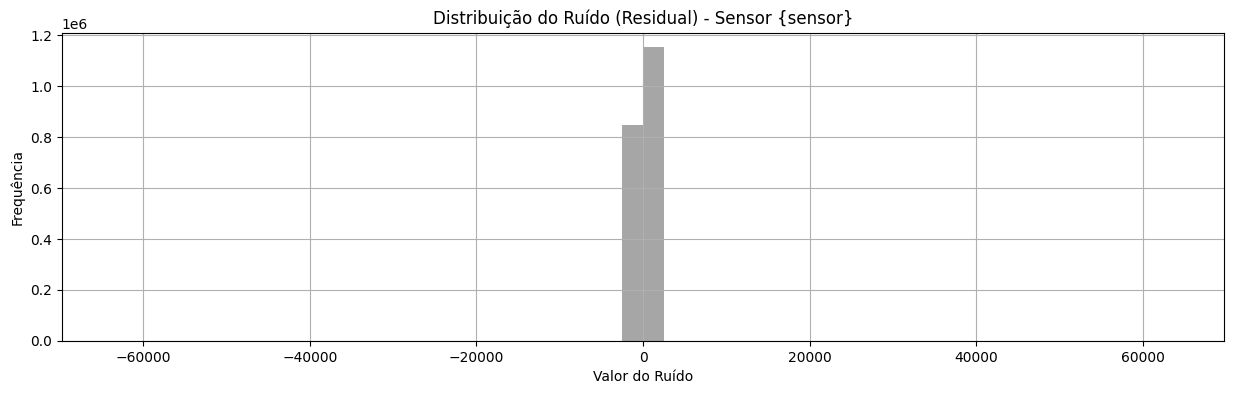

In [9]:
# Plotando o Ruído (exibindo apenas os primeiros 10.000 pontos)
index_start_resid = 0
index_end_resid = 10000

plt.figure(figsize=(15, 4))
plt.plot(indices[index_start_resid:index_end_resid + index_start_resid],
         result.resid[index_start_resid:index_end_resid + index_start_resid], color='red')
plt.title(f'Ruído (Primeiros {index_end_resid} pontos) - Sensor {sensor}')
plt.ylabel('Valor')
plt.xlabel('Índice')
plt.grid()
plt.show()

# Analisando a distribuição do ruído
plt.figure(figsize=(15, 4))
plt.hist(result.resid.dropna(), bins=50, color='grey', alpha=0.7)
plt.title('Distribuição do Ruído (Residual) - Sensor {sensor}')
plt.xlabel('Valor do Ruído')
plt.ylabel('Frequência')
plt.grid()
plt.show()

## Aplicação do Algoritmo de Detecção de Anomalias

In [10]:
# Função para calcular Z-Score
def z_score_anomaly_detection(data, threshold=3):
    mean = np.mean(data)
    std_dev = np.std(data)
    
    z_scores = np.abs((data - mean) / std_dev)
    anomalies = z_scores > threshold
    
    return anomalies, z_scores

# Preenchendo os NaNs em result.resid usando interpolação
result_resid_filled = result.resid.interpolate(method='linear')

# Certifique-se de que todos os NaNs foram preenchidos
if result_resid_filled.isnull().sum() > 0:
    result_resid_filled = result_resid_filled.fillna(method='bfill').fillna(method='ffill')

# Extrair somente os valores, ignorando o índice de datas
resid_values = result_resid_filled.values

# Detectar anomalias usando Z-Score
anomalies_z, z_scores = z_score_anomaly_detection(resid_values)

# Identificar os índices das anomalias
anomaly_indices_z = np.where(anomalies_z)[0]

# Verificar os resultados intermediários
print("Resíduos:", resid_values[:10])
print("Z-Scores:", z_scores[:10])
print("Anomalies Detected:", anomaly_indices_z[:10])

Resíduos: [7.22857357 7.22857357 7.22857357 7.22857357 7.22857357 7.22857357
 7.22857357 7.22857357 7.22857357 7.22857357]
Z-Scores: [0.0094137 0.0094137 0.0094137 0.0094137 0.0094137 0.0094137 0.0094137
 0.0094137 0.0094137 0.0094137]
Anomalies Detected: [1166725 1166726 1166727 1166728 1166729 1166730 1166731 1166732 1166733
 1166734]


/var/folders/gf/g8dcf52n0dq7yk1470h3ctrr0000gn/T/ipykernel_57586/882764958.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result_resid_filled = result_resid_filled.fillna(method='bfill').fillna(method='ffill')


## Plotagem dos Resultados das Anomalias

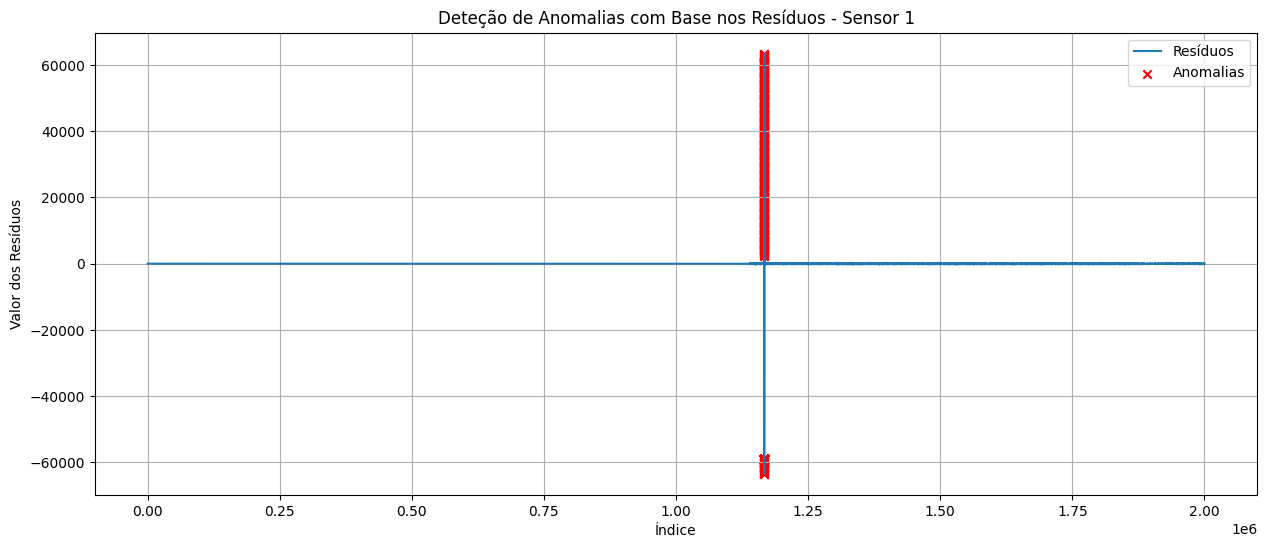

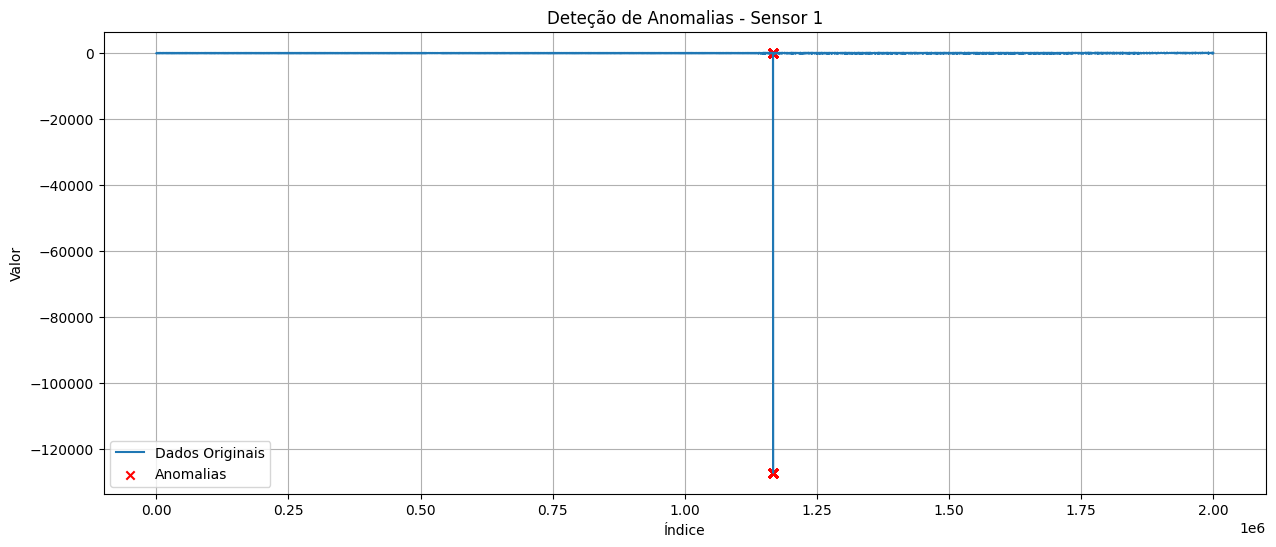

In [11]:
# Plotar os resultados das anomalias nos resíduos
plt.figure(figsize=(15, 6))
plt.plot(resid_values, label='Resíduos')
plt.scatter(anomaly_indices_z, resid_values[anomaly_indices_z], color='red', label='Anomalias', marker='x')
plt.title(f'Deteção de Anomalias com Base nos Resíduos - Sensor {sensor}')
plt.xlabel('Índice')
plt.ylabel('Valor dos Resíduos')
plt.legend()
plt.grid()
plt.show()

# Plotar os resultados com os dados originais
plt.figure(figsize=(15, 6))
plt.plot(sensor_data_sample.values, label='Dados Originais')
plt.scatter(anomaly_indices_z, sensor_data_sample.values[anomaly_indices_z], color='red', label='Anomalias', marker='x')
plt.title(f'Deteção de Anomalias - Sensor {sensor}')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.grid()
plt.show()

# Sensor 2

## Decomposição do Sinal

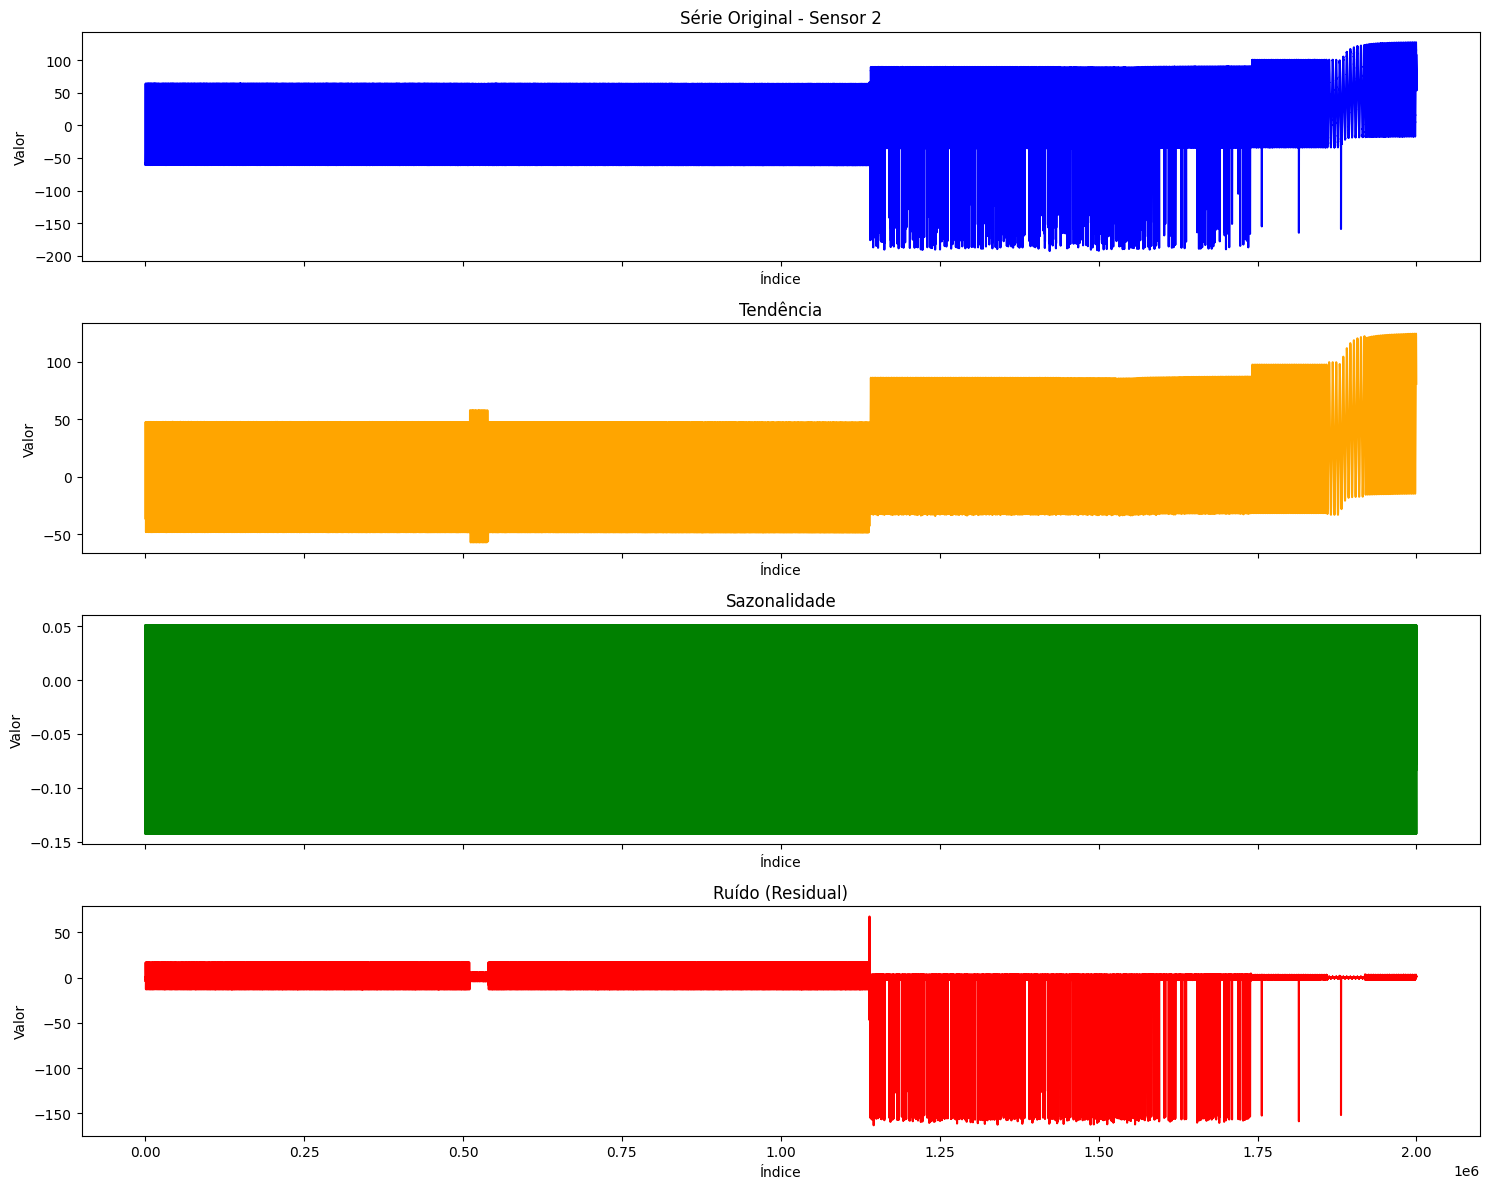

In [12]:
# Selecionar os dados do Sensor 2
sensor = 2
sensor_index = sensor - 1

# Selecionar os dados do Sensor 2
sensor_data_sample = sensor_data.iloc[:, sensor_index]

# Decompor os dados do Sensor 2
result = seasonal_decompose(sensor_data_sample, model='additive', period=365)

# Criando uma lista de índices para representar o eixo x
indices = range(len(sensor_data_sample))

# Plotando os componentes com Matplotlib
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

# Plotar a série original
axes[0].plot(indices, sensor_data_sample, color='blue')
axes[0].set_title(f'Série Original - Sensor {sensor}')
axes[0].set_ylabel('Valor')
axes[0].set_xlabel('Índice')

# Plotar a tendência
axes[1].plot(indices, result.trend, color='orange')
axes[1].set_title('Tendência')
axes[1].set_ylabel('Valor')
axes[1].set_xlabel('Índice')

# Plotar a sazonalidade
axes[2].plot(indices, result.seasonal, color='green')
axes[2].set_title('Sazonalidade')
axes[2].set_ylabel('Valor')
axes[2].set_xlabel('Índice')

# Plotar o ruído (residual)
axes[3].plot(indices, result.resid, color='red')
axes[3].set_title('Ruído (Residual)')
axes[3].set_ylabel('Valor')
axes[3].set_xlabel('Índice')

# Ajustar layout
plt.tight_layout()
plt.show()

## Verificação da Sazonalidade

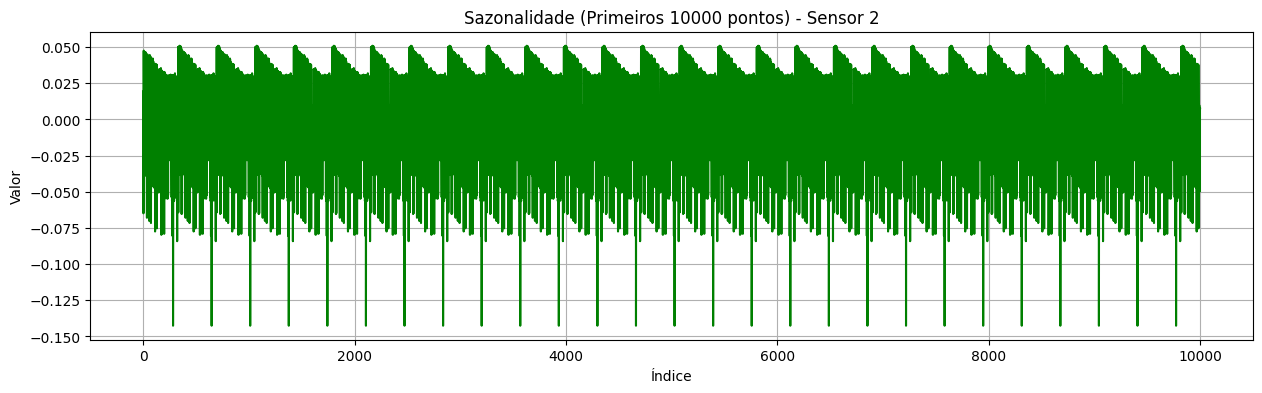

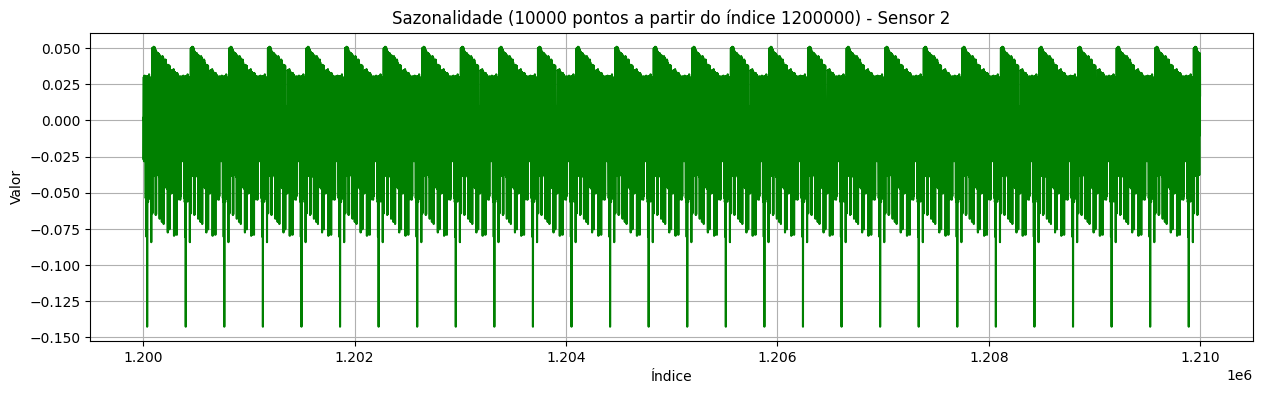

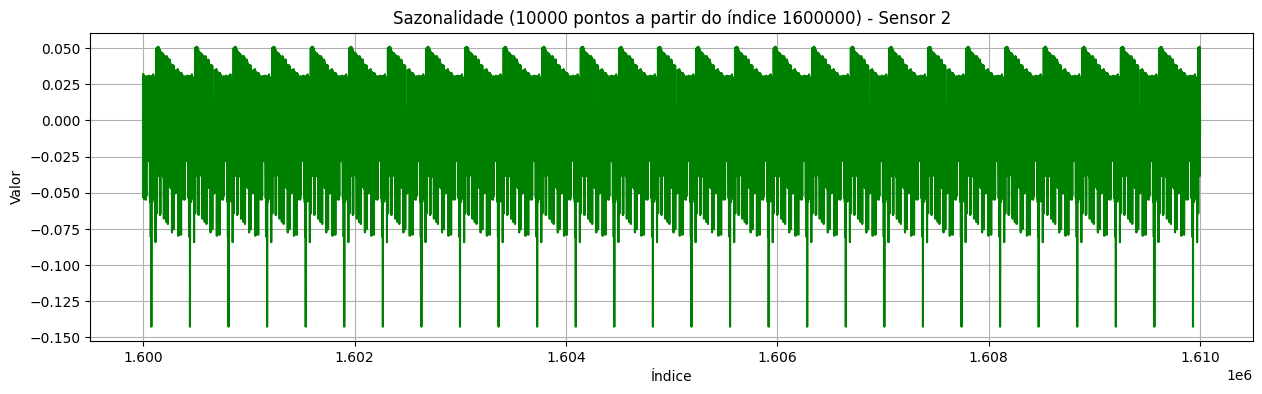

In [13]:
# Plotando a sazonalidade (exibindo apenas os primeiros 10.000 pontos)
index_start_saz = 0
index_end_saz = 10000

plt.figure(figsize=(15, 4))
plt.plot(indices[index_start_saz:index_end_saz + index_start_saz], 
         result.seasonal[index_start_saz:index_end_saz + index_start_saz], color='green')
plt.title(f'Sazonalidade (Primeiros {index_end_saz} pontos) - Sensor {sensor}')
plt.ylabel('Valor')
plt.xlabel('Índice')
plt.grid()
plt.show()

# Plotando a sazonalidade (exibindo a partir do índice 1200000 por 10000 pontos)
index_start_saz = 1200000
index_end_saz = 10000

plt.figure(figsize=(15, 4))
plt.plot(indices[index_start_saz:index_end_saz + index_start_saz], 
         result.seasonal[index_start_saz:index_end_saz + index_start_saz], color='green')
plt.title(f'Sazonalidade ({index_end_saz} pontos a partir do índice {index_start_saz}) - Sensor {sensor}')
plt.ylabel('Valor')
plt.xlabel('Índice')
plt.grid()
plt.show()

# Plotando a sazonalidade (exibindo a partir do índice 1600000 por 10000 pontos)
index_start_saz = 1600000
index_end_saz = 10000

plt.figure(figsize=(15, 4))
plt.plot(indices[index_start_saz:index_end_saz + index_start_saz], 
         result.seasonal[index_start_saz:index_end_saz + index_start_saz], color='green')
plt.title(f'Sazonalidade ({index_end_saz} pontos a partir do índice {index_start_saz}) - Sensor {sensor}')
plt.ylabel('Valor')
plt.xlabel('Índice')
plt.grid()
plt.show()

## Verificação do Ruído (Residual)

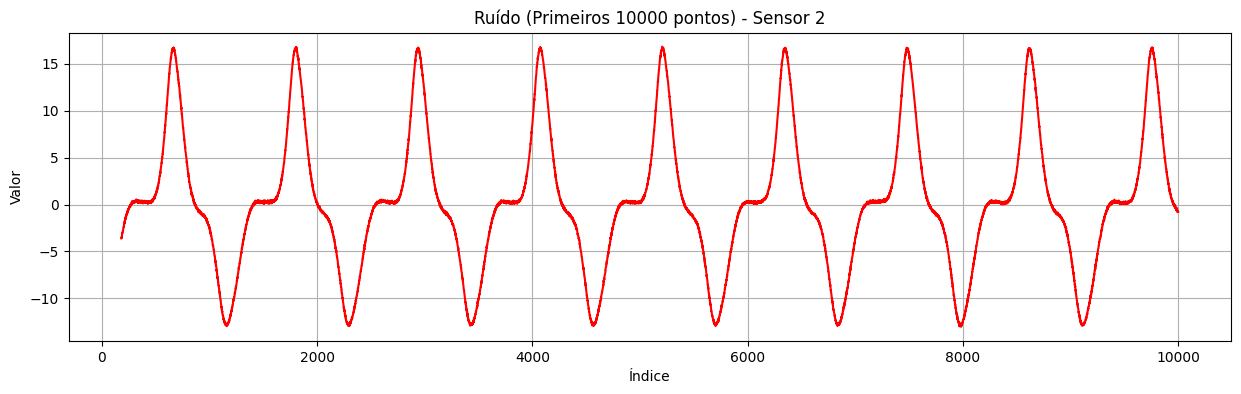

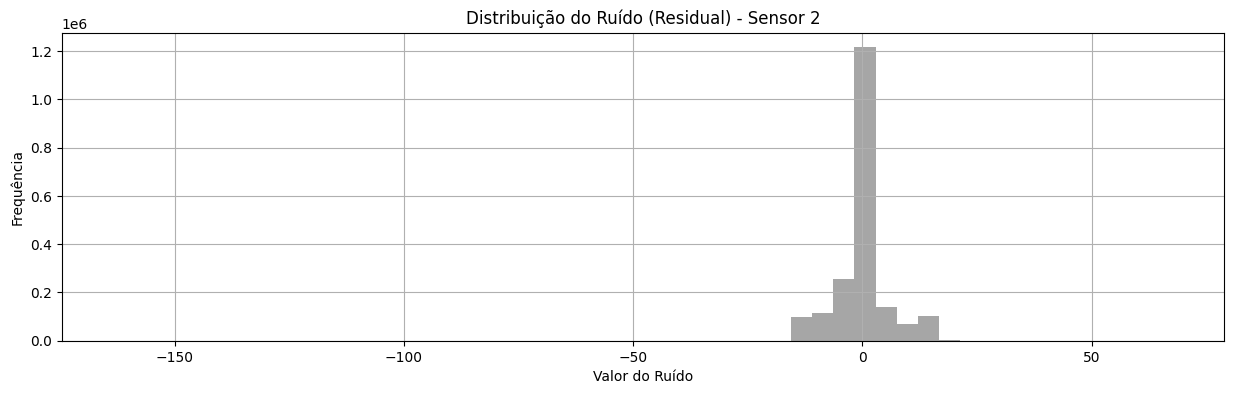

In [14]:
# Plotando o Ruído (exibindo apenas os primeiros 10.000 pontos)
index_start_resid = 0
index_end_resid = 10000

plt.figure(figsize=(15, 4))
plt.plot(indices[index_start_resid:index_end_resid + index_start_resid],
         result.resid[index_start_resid:index_end_resid + index_start_resid], color='red')
plt.title(f'Ruído (Primeiros {index_end_resid} pontos) - Sensor {sensor}')
plt.ylabel('Valor')
plt.xlabel('Índice')
plt.grid()
plt.show()

# Analisando a distribuição do ruído
plt.figure(figsize=(15, 4))
plt.hist(result.resid.dropna(), bins=50, color='grey', alpha=0.7)
plt.title(f'Distribuição do Ruído (Residual) - Sensor {sensor}')
plt.xlabel('Valor do Ruído')
plt.ylabel('Frequência')
plt.grid()
plt.show()

## Detecção de Anomalias

In [15]:
# Função para calcular Z-Score
def z_score_anomaly_detection(data, threshold=3):
    mean = np.mean(data)
    std_dev = np.std(data)
    
    z_scores = np.abs((data - mean) / std_dev)
    anomalies = z_scores > threshold
    
    return anomalies, z_scores

# Preenchendo os NaNs em result.resid usando interpolação
result_resid_filled = result.resid.interpolate(method='linear')

# Certifique-se de que todos os NaNs foram preenchidos
if result_resid_filled.isnull().sum() > 0:
    result_resid_filled = result_resid_filled.fillna(method='bfill').fillna(method='ffill')

# Extrair somente os valores, ignorando o índice de datas
resid_values = result_resid_filled.values

# Detectar anomalias usando Z-Score
anomalies_z, z_scores = z_score_anomaly_detection(resid_values)

# Identificar os índices das anomalias
anomaly_indices_z = np.where(anomalies_z)[0]

# Verificar os resultados intermediários
print("Resíduos:", resid_values[:10])
print("Z-Scores:", z_scores[:10])
print("Anomalies Detected:", anomaly_indices_z[:10])

Resíduos: [-3.61537776 -3.61537776 -3.61537776 -3.61537776 -3.61537776 -3.61537776
 -3.61537776 -3.61537776 -3.61537776 -3.61537776]
Z-Scores: [0.59736596 0.59736596 0.59736596 0.59736596 0.59736596 0.59736596
 0.59736596 0.59736596 0.59736596 0.59736596]
Anomalies Detected: [1139332 1139333 1139334 1139335 1139336 1139337 1139338 1139339 1139340
 1139341]


/var/folders/gf/g8dcf52n0dq7yk1470h3ctrr0000gn/T/ipykernel_57586/882764958.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result_resid_filled = result_resid_filled.fillna(method='bfill').fillna(method='ffill')


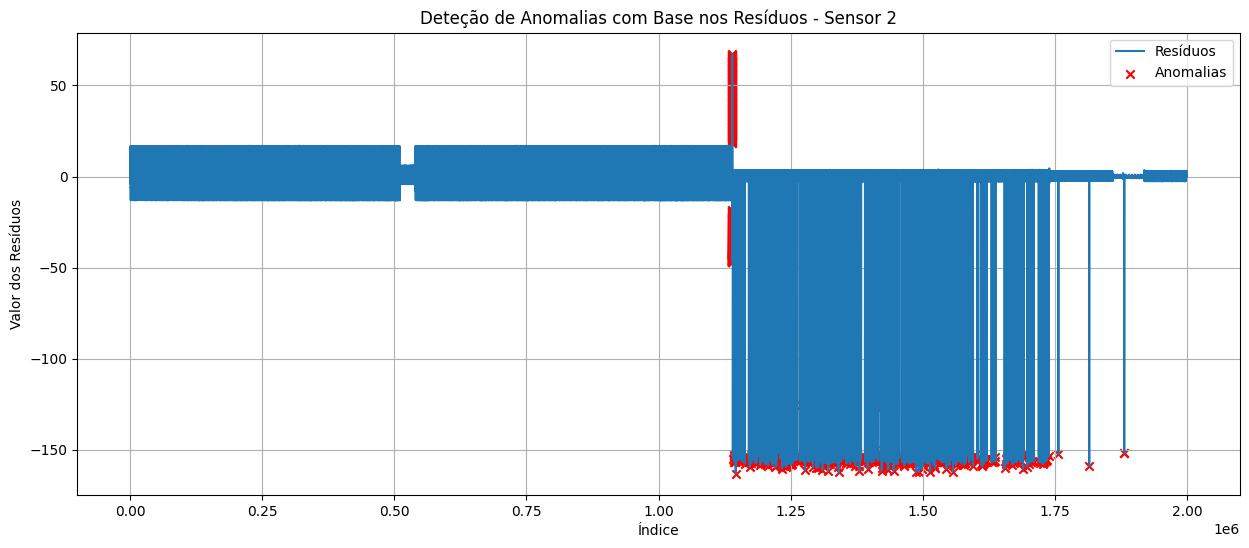

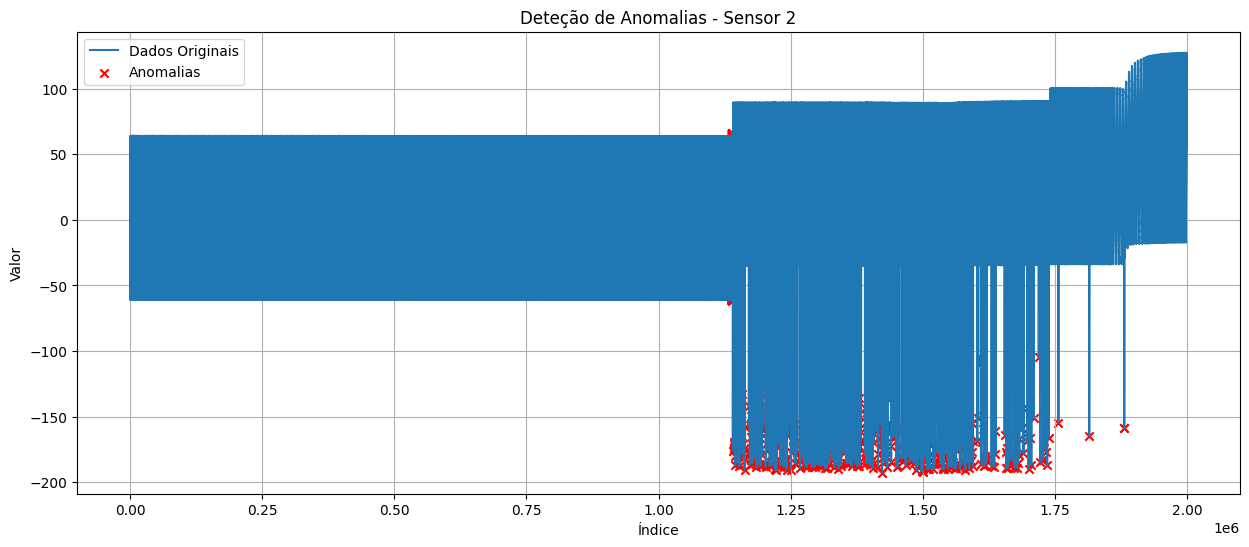

In [16]:
# Plotar os resultados das anomalias nos resíduos
plt.figure(figsize=(15, 6))
plt.plot(resid_values, label='Resíduos')
plt.scatter(anomaly_indices_z, resid_values[anomaly_indices_z], color='red', label='Anomalias', marker='x')
plt.title(f'Deteção de Anomalias com Base nos Resíduos - Sensor {sensor}')
plt.xlabel('Índice')
plt.ylabel('Valor dos Resíduos')
plt.legend()
plt.grid()
plt.show()

# Plotar os resultados com os dados originais
plt.figure(figsize=(15, 6))
plt.plot(sensor_data_sample.values, label='Dados Originais')
plt.scatter(anomaly_indices_z, sensor_data_sample.values[anomaly_indices_z], color='red', label='Anomalias', marker='x')
plt.title(f'Deteção de Anomalias - Sensor {sensor}')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.grid()
plt.show()

# Sensor 3

## Decomposição do Sinal

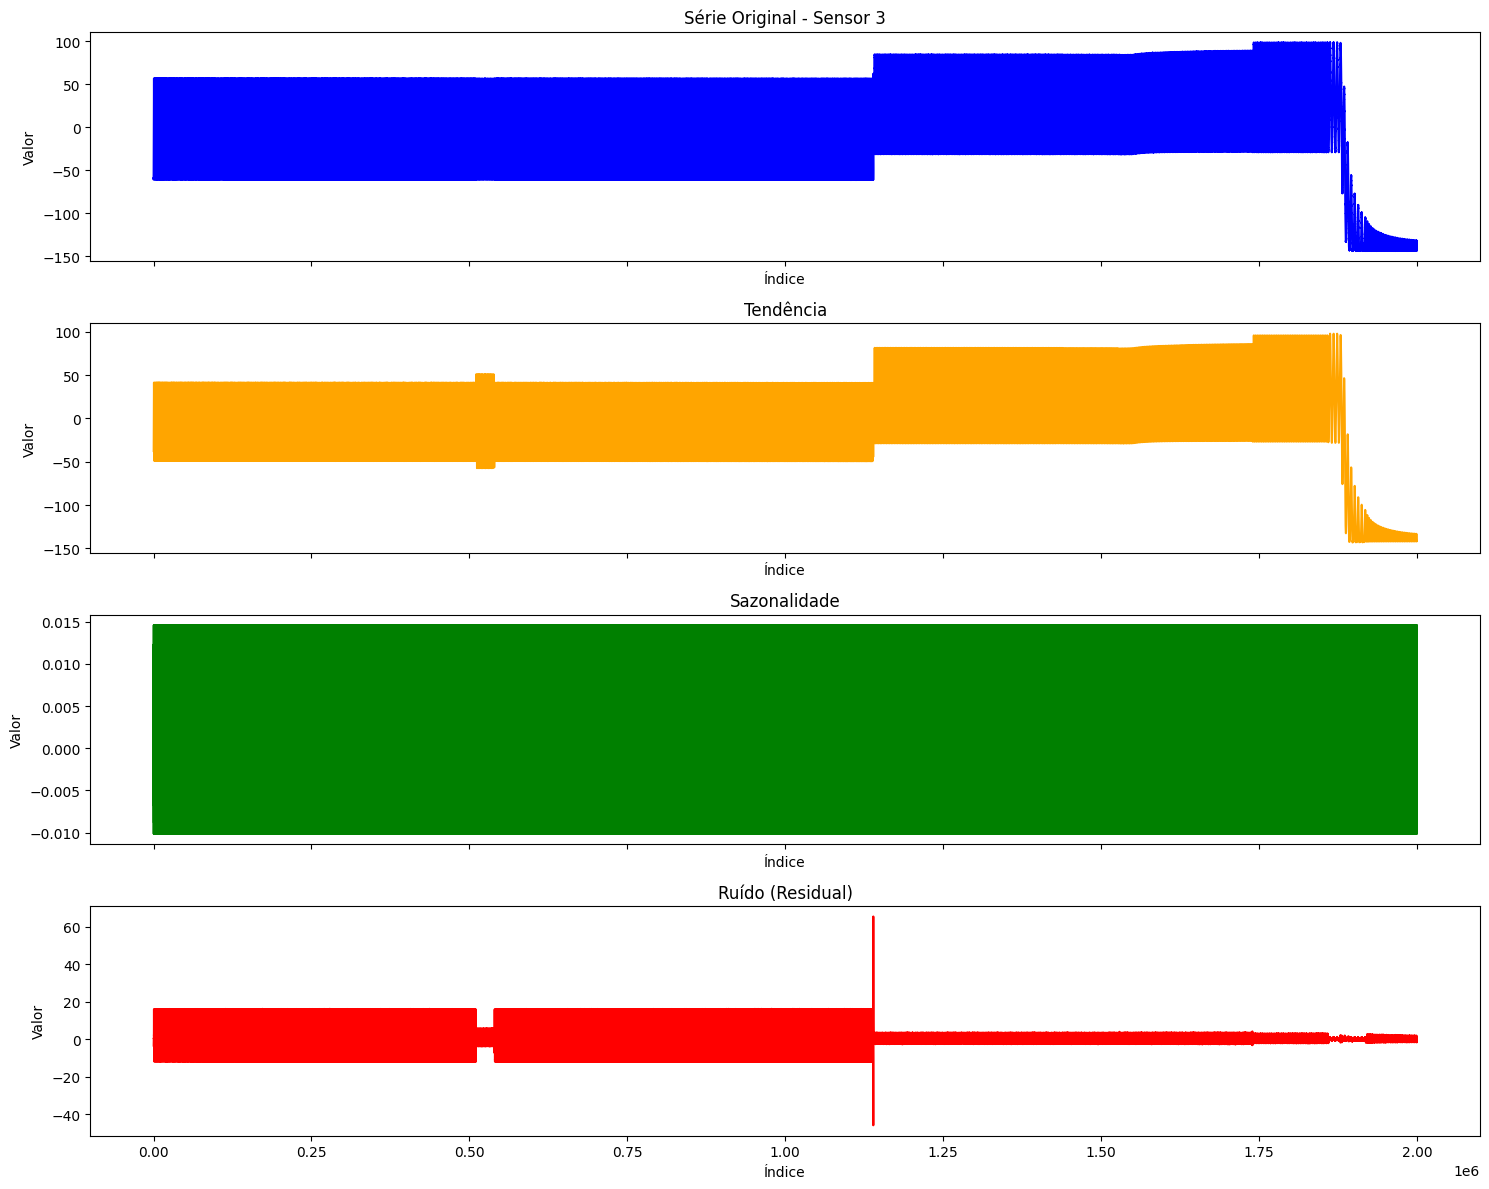

In [17]:
# Selecionar os dados do Sensor 3
sensor = 3
sensor_index = sensor - 1

# Selecionar os dados do Sensor 3
sensor_data_sample = sensor_data.iloc[:, sensor_index]

# Decompor os dados do Sensor 3
result = seasonal_decompose(sensor_data_sample, model='additive', period=365)

# Criando uma lista de índices para representar o eixo x
indices = range(len(sensor_data_sample))

# Plotando os componentes com Matplotlib
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

# Plotar a série original
axes[0].plot(indices, sensor_data_sample, color='blue')
axes[0].set_title(f'Série Original - Sensor {sensor}')
axes[0].set_ylabel('Valor')
axes[0].set_xlabel('Índice')

# Plotar a tendência
axes[1].plot(indices, result.trend, color='orange')
axes[1].set_title('Tendência')
axes[1].set_ylabel('Valor')
axes[1].set_xlabel('Índice')

# Plotar a sazonalidade
axes[2].plot(indices, result.seasonal, color='green')
axes[2].set_title('Sazonalidade')
axes[2].set_ylabel('Valor')
axes[2].set_xlabel('Índice')

# Plotar o ruído (residual)
axes[3].plot(indices, result.resid, color='red')
axes[3].set_title('Ruído (Residual)')
axes[3].set_ylabel('Valor')
axes[3].set_xlabel('Índice')

# Ajustar layout
plt.tight_layout()
plt.show()

## Verificação da Sazonalidade

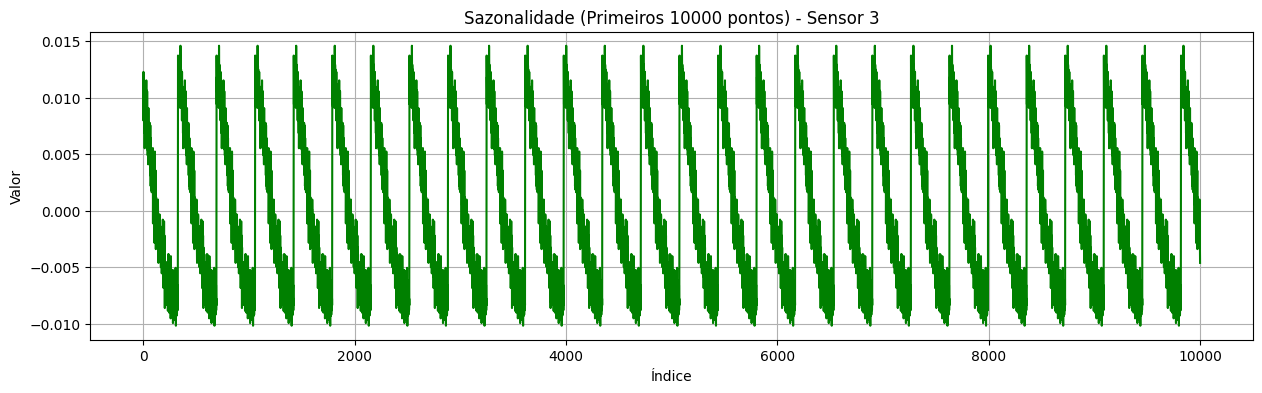

In [18]:
# Plotando a sazonalidade (exibindo apenas os primeiros 10.000 pontos)
index_start_saz = 0
index_end_saz = 10000

plt.figure(figsize=(15, 4))
plt.plot(indices[index_start_saz:index_end_saz + index_start_saz], 
         result.seasonal[index_start_saz:index_end_saz + index_start_saz], color='green')
plt.title(f'Sazonalidade (Primeiros {index_end_saz} pontos) - Sensor {sensor}')
plt.ylabel('Valor')
plt.xlabel('Índice')
plt.grid()
plt.show()

## Verificação do Ruído (Residual)

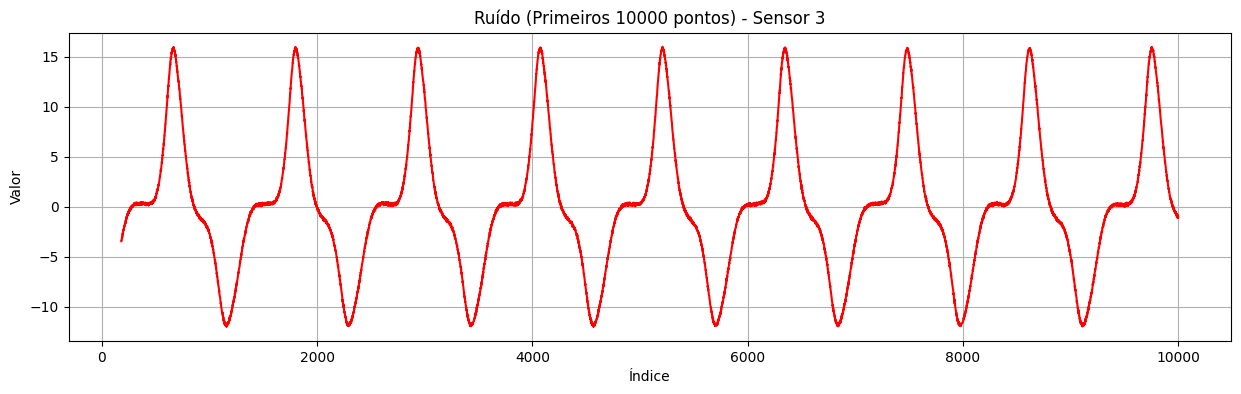

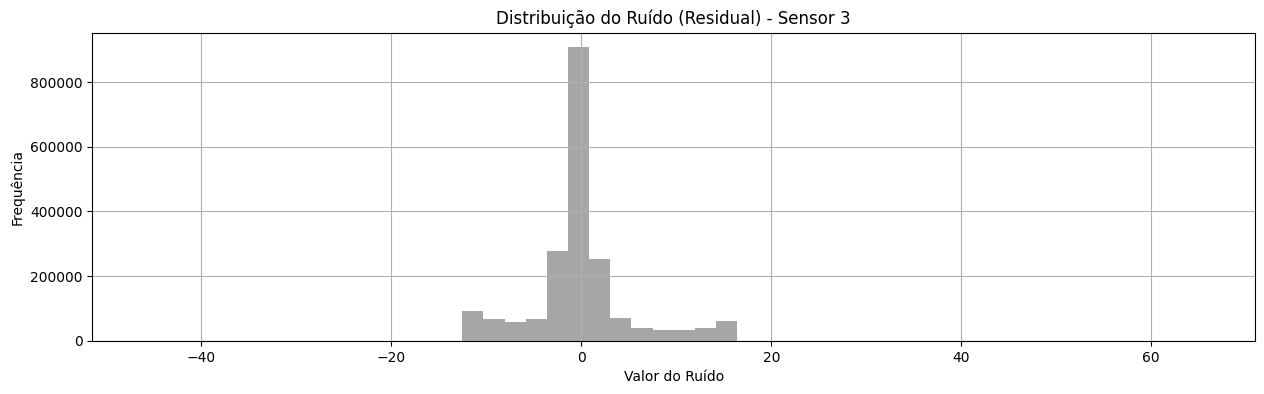

In [19]:
# Plotando o Ruído (exibindo apenas os primeiros 10.000 pontos)
index_start_resid = 0
index_end_resid = 10000

plt.figure(figsize=(15, 4))
plt.plot(indices[index_start_resid:index_end_resid + index_start_resid],
         result.resid[index_start_resid:index_end_resid + index_start_resid], color='red')
plt.title(f'Ruído (Primeiros {index_end_resid} pontos) - Sensor {sensor}')
plt.ylabel('Valor')
plt.xlabel('Índice')
plt.grid()
plt.show()

# Analisando a distribuição do ruído
plt.figure(figsize=(15, 4))
plt.hist(result.resid.dropna(), bins=50, color='grey', alpha=0.7)
plt.title(f'Distribuição do Ruído (Residual) - Sensor {sensor}')
plt.xlabel('Valor do Ruído')
plt.ylabel('Frequência')
plt.grid()
plt.show()

In [20]:
# Preenchendo os NaNs em result.resid usando interpolação
result_resid_filled = result.resid.interpolate(method='linear')

# Certifique-se de que todos os NaNs foram preenchidos
if result_resid_filled.isnull().sum() > 0:
    result_resid_filled = result_resid_filled.fillna(method='bfill').fillna(method='ffill')

# Extrair somente os valores, ignorando o índice de datas
resid_values = result_resid_filled.values

# Normalizar os dados
scaler = StandardScaler()
resid_values_scaled = scaler.fit_transform(resid_values.reshape(-1, 1))

# Detectar anomalias usando Isolation Forest
model = IsolationForest(contamination=0.01)  # Ajuste a contaminação conforme necessário
model.fit(resid_values_scaled)

# Prever anomalias
anomaly_labels = model.predict(resid_values_scaled)  # -1 indica anomalias
anomaly_indices = np.where(anomaly_labels == -1)[0]

# Verificar os resultados intermediários
print("Anomalies Detected (Isolation Forest):", anomaly_indices)

/var/folders/gf/g8dcf52n0dq7yk1470h3ctrr0000gn/T/ipykernel_57586/3239760333.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result_resid_filled = result_resid_filled.fillna(method='bfill').fillna(method='ffill')


NameError: name 'StandardScaler' is not defined

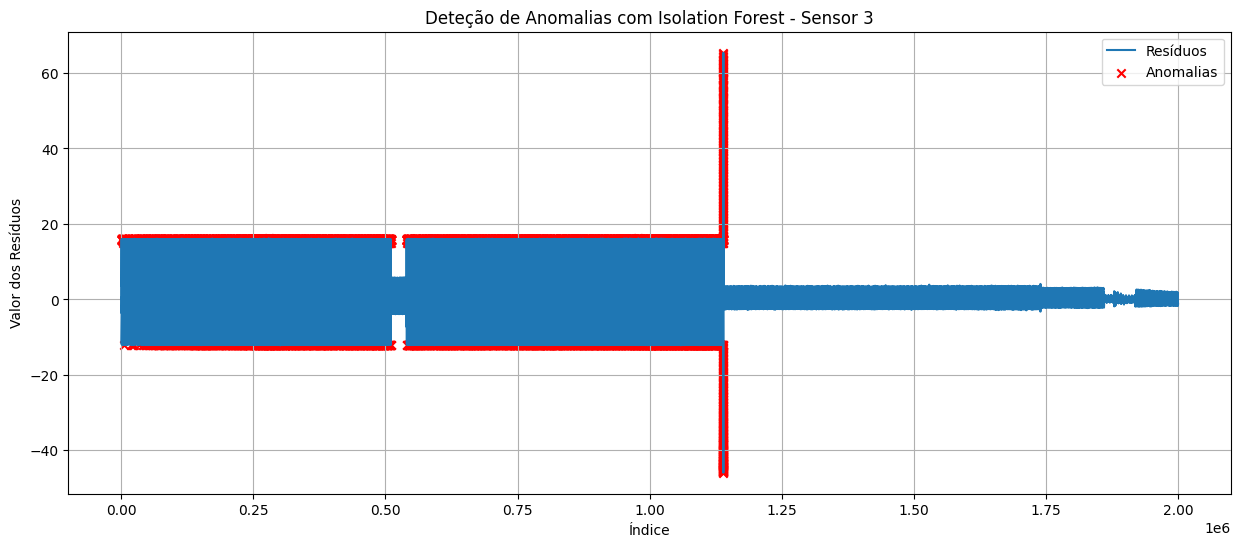

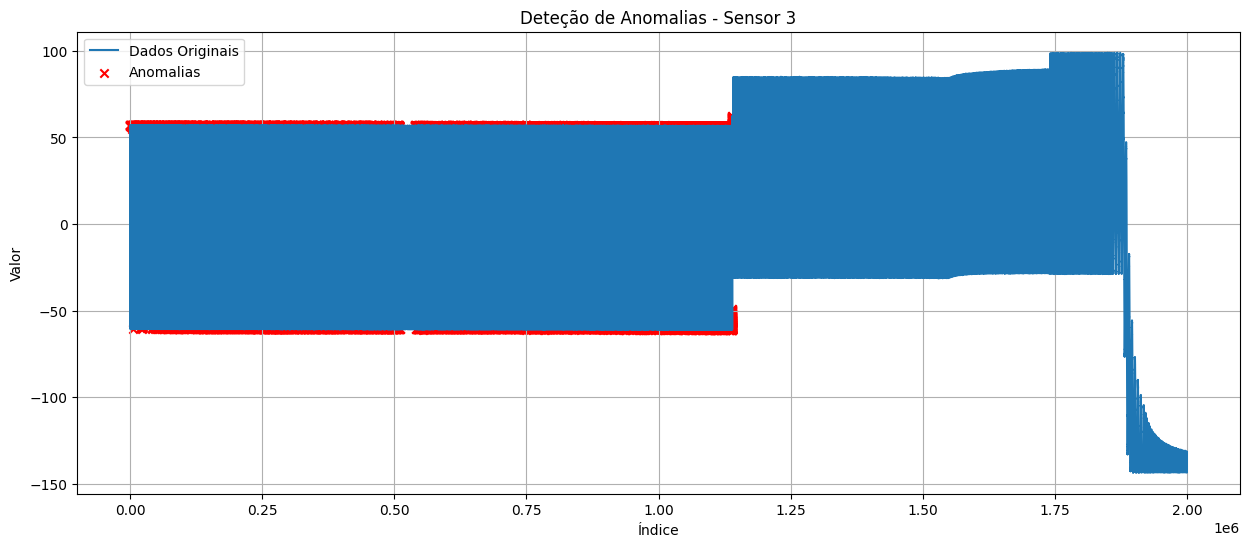

In [19]:
# Plotar os resultados das anomalias nos resíduos
plt.figure(figsize=(15, 6))
plt.plot(result_resid_filled.values, label='Resíduos')
plt.scatter(anomaly_indices, result_resid_filled.values[anomaly_indices], color='red', label='Anomalias', marker='x')
plt.title(f'Deteção de Anomalias com Isolation Forest - Sensor {sensor}')
plt.xlabel('Índice')
plt.ylabel('Valor dos Resíduos')
plt.legend()
plt.grid()
plt.show()

# Plotar os resultados com os dados originais
plt.figure(figsize=(15, 6))
plt.plot(sensor_data_sample.values, label='Dados Originais')
plt.scatter(anomaly_indices, sensor_data_sample.values[anomaly_indices], color='red', label='Anomalias', marker='x')
plt.title(f'Deteção de Anomalias - Sensor {sensor}')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.grid()
plt.show()

## Detecção de Anomalias

In [34]:
# Preenchendo os NaNs em result.resid usando interpolação
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import IsolationForest


result_resid_filled = result.resid.interpolate(method='linear')

# Certifique-se de que todos os NaNs foram preenchidos
if result_resid_filled.isnull().sum() > 0:
    result_resid_filled = result_resid_filled.fillna(method='bfill').fillna(method='ffill')

# Extrair somente os valores, ignorando o índice de datas
resid_values = result_resid_filled.values.reshape(-1, 1)
dates = pd.to_datetime(arr_1)
sensor_data = pd.DataFrame(arr_0, index=dates)

# Exibir as primeiras linhas do DataFrame para verificar se os dados foram carregados corretamente
print(sensor_data.head())

# Normalizar os dados
scaler = StandardScaler()
sensor_data_normalized = scaler.fit_transform(sensor_data)

# Selecionar os dados do sensor 3
sensor_3_data = sensor_data_normalized[:, 2]

# Detectar anomalias usando Isolation Forest
model = IsolationForest(contamination=0.06)
model.fit(sensor_3_data.reshape(-1, 1))
anomaly_labels = model.predict(sensor_3_data.reshape(-1, 1))
anomaly_indices = np.where(anomaly_labels == -1)[0]

# Verificar os resultados intermediários
print("Anomalies Detected (Isolation Forest):", anomaly_indices)

/var/folders/gf/g8dcf52n0dq7yk1470h3ctrr0000gn/T/ipykernel_32323/2481531806.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result_resid_filled = result_resid_filled.fillna(method='bfill').fillna(method='ffill')


                                    0          1          2          3  \
2015-10-09 23:48:31.152250 -58.906185 -58.763771 -58.896015 -58.723080   
2015-10-09 23:48:31.160250 -58.906185 -58.794289 -58.896015 -58.896015   
2015-10-09 23:48:31.168250 -58.967220 -58.957050 -58.896015 -59.068947   
2015-10-09 23:48:31.176250 -59.119808 -59.089291 -59.058773 -58.896015   
2015-10-09 23:48:31.184250 -59.282570 -59.119808 -59.231709 -59.068947   

                                    4          5          6          7  \
2015-10-09 23:48:31.152250 -59.119808 -58.855324 -58.916359 -58.763771   
2015-10-09 23:48:31.160250 -59.119808 -58.896015 -58.916359 -58.763771   
2015-10-09 23:48:31.168250 -58.957050 -58.896015 -58.916359 -59.079121   
2015-10-09 23:48:31.176250 -59.282570 -59.170673 -59.079121 -59.109638   
2015-10-09 23:48:31.184250 -59.119808 -59.170673 -59.241879 -59.109638   

                                    8          9  
2015-10-09 23:48:31.152250 -58.723080 -58.529804  
2015-10-

## Plotagem dos Resultados das Anomalias

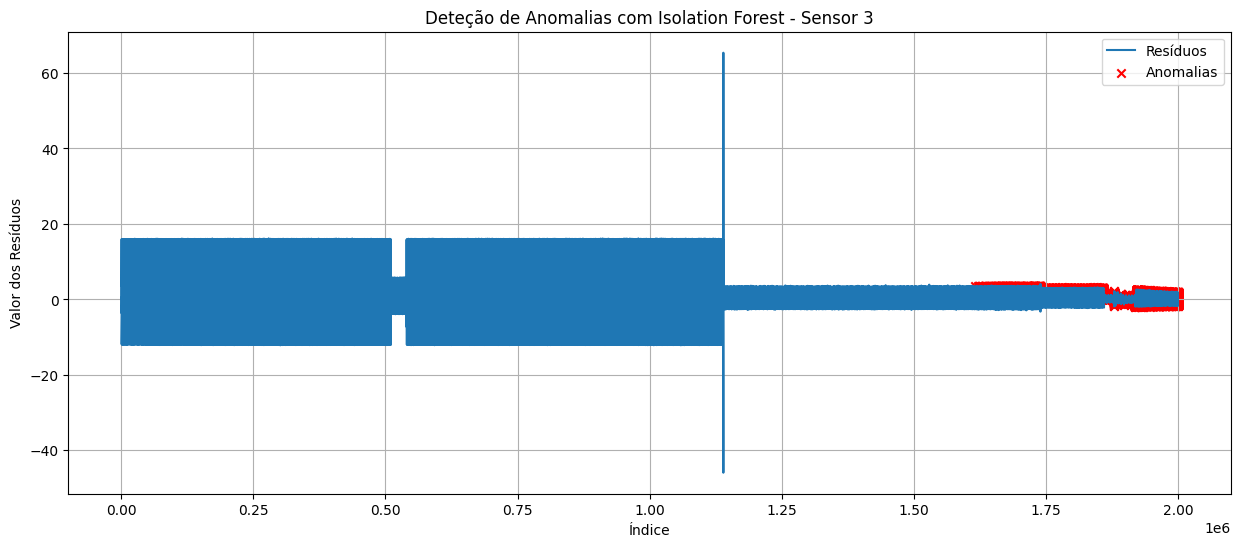

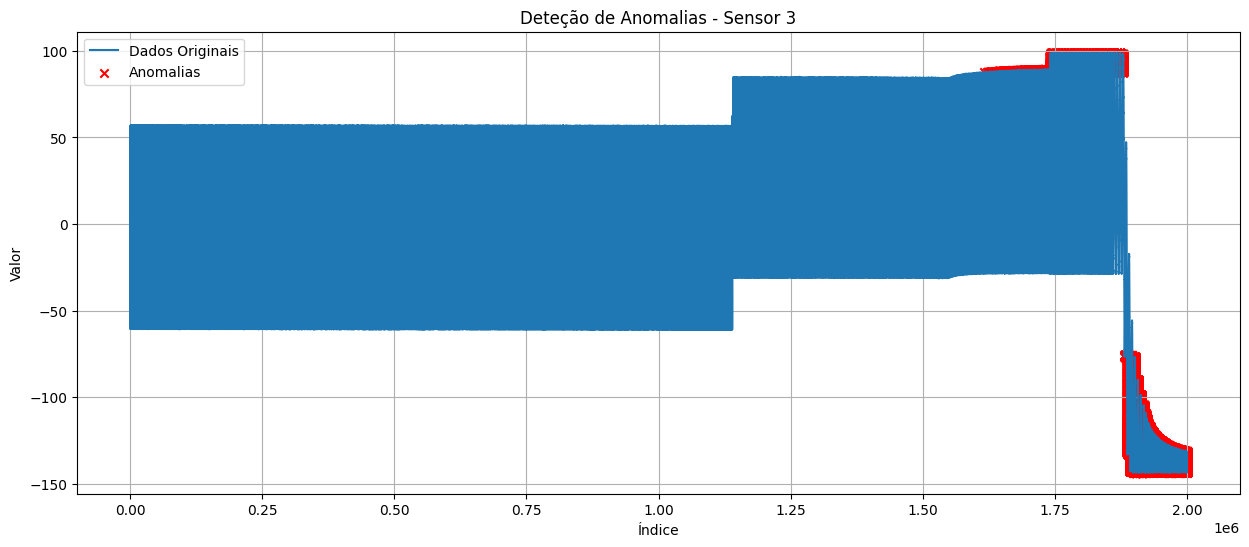

In [35]:
# Plotar os resultados das anomalias nos resíduos
plt.figure(figsize=(15, 6))
plt.plot(result_resid_filled.values, label='Resíduos')
plt.scatter(anomaly_indices, result_resid_filled.values[anomaly_indices], color='red', label='Anomalias', marker='x')
plt.title(f'Deteção de Anomalias com Isolation Forest - Sensor {sensor}')
plt.xlabel('Índice')
plt.ylabel('Valor dos Resíduos')
plt.legend()
plt.grid()
plt.show()

# Plotar os resultados com os dados originais
plt.figure(figsize=(15, 6))
plt.plot(sensor_data_sample.values, label='Dados Originais')
plt.scatter(anomaly_indices, sensor_data_sample.values[anomaly_indices], color='red', label='Anomalias', marker='x')
plt.title(f'Deteção de Anomalias - Sensor {sensor}')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.grid()
plt.show()

                                    0          1          2          3  \
2015-10-09 23:48:31.152250 -58.906185 -58.763771 -58.896015 -58.723080   
2015-10-09 23:48:31.160250 -58.906185 -58.794289 -58.896015 -58.896015   
2015-10-09 23:48:31.168250 -58.967220 -58.957050 -58.896015 -59.068947   
2015-10-09 23:48:31.176250 -59.119808 -59.089291 -59.058773 -58.896015   
2015-10-09 23:48:31.184250 -59.282570 -59.119808 -59.231709 -59.068947   

                                    4          5          6          7  \
2015-10-09 23:48:31.152250 -59.119808 -58.855324 -58.916359 -58.763771   
2015-10-09 23:48:31.160250 -59.119808 -58.896015 -58.916359 -58.763771   
2015-10-09 23:48:31.168250 -58.957050 -58.896015 -58.916359 -59.079121   
2015-10-09 23:48:31.176250 -59.282570 -59.170673 -59.079121 -59.109638   
2015-10-09 23:48:31.184250 -59.119808 -59.170673 -59.241879 -59.109638   

                                    8          9  
2015-10-09 23:48:31.152250 -58.723080 -58.529804  
2015-10-

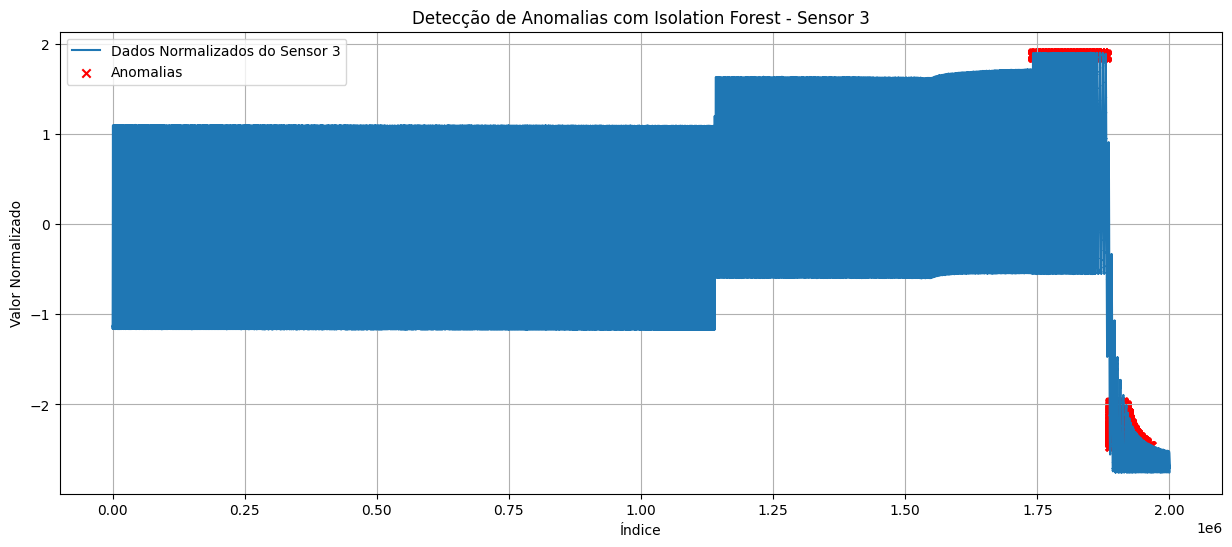

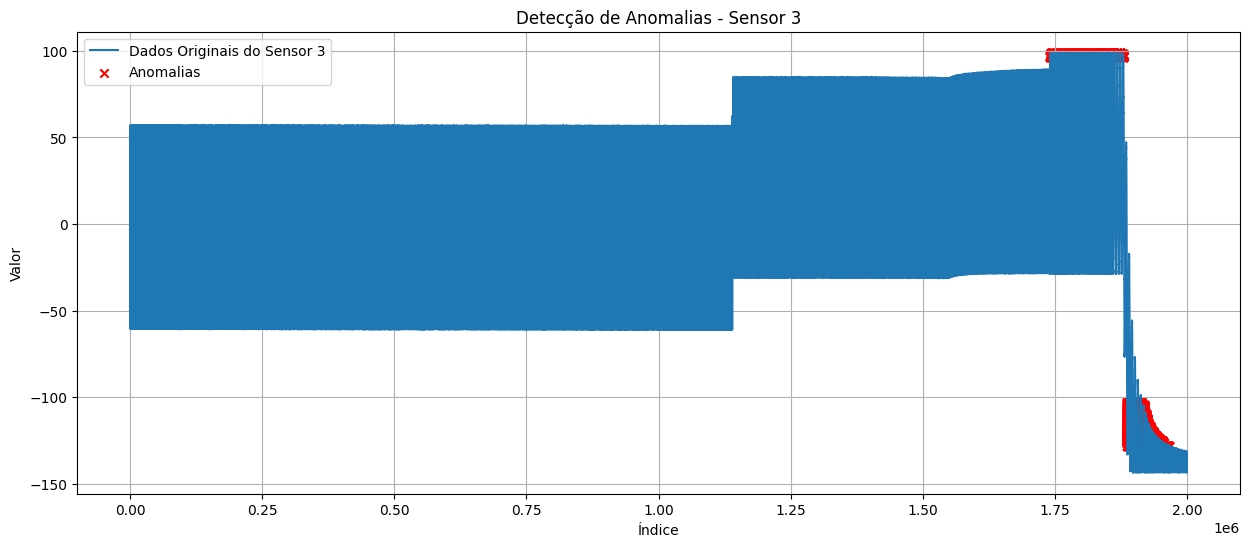

In [9]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

# Carregar os dados
file_path = 'dataset_shrink_transformed.npz'  # Ajuste o caminho conforme necessário
data = np.load(file_path)
arr_0 = data['arr_0']
arr_1 = data['arr_1']

# Criar DataFrame com os dados do sensor
dates = pd.to_datetime(arr_1)
sensor_data = pd.DataFrame(arr_0, index=dates)

# Exibir as primeiras linhas do DataFrame para verificar se os dados foram carregados corretamente
print(sensor_data.head())

# Normalizar os dados
scaler = StandardScaler()
sensor_data_normalized = scaler.fit_transform(sensor_data)

# Selecionar os dados do sensor 3
sensor_3_data = sensor_data_normalized[:, 2]

# Detectar anomalias usando Isolation Forest
model = IsolationForest(contamination=0.01)
model.fit(sensor_3_data.reshape(-1, 1))
anomaly_labels = model.predict(sensor_3_data.reshape(-1, 1))

# Identificar os índices das anomalias
anomaly_indices = np.where(anomaly_labels == -1)[0]

# Plotar os resultados das anomalias nos resíduos
plt.figure(figsize=(15, 6))
plt.plot(sensor_3_data, label='Dados Normalizados do Sensor 3')
plt.scatter(anomaly_indices, sensor_3_data[anomaly_indices], color='red', label='Anomalias', marker='x')
plt.title('Detecção de Anomalias com Isolation Forest - Sensor 3')
plt.xlabel('Índice')
plt.ylabel('Valor Normalizado')
plt.legend()
plt.grid()
plt.show()

# Plotar os resultados com os dados originais
plt.figure(figsize=(15, 6))
plt.plot(sensor_data.iloc[:, 2].values, label='Dados Originais do Sensor 3')
plt.scatter(anomaly_indices, sensor_data.iloc[:, 2].values[anomaly_indices], color='red', label='Anomalias', marker='x')
plt.title('Detecção de Anomalias - Sensor 3')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.grid()
plt.show()